![](./figures/Logo.PNG)

## In this part of the tutorial, you will
* use a genetic algorithm to optimize model outputs globally
* critically assess the optimized parameters and objective function results
* implement and use your own objective function(s) 

- - -

# 2 d - Optimization

- - -

## 1 About optimization

In the previous tutorials, we have relied on our own capacity to tune the input parameters of our model. In this tutorial, we will use an algorithm to do this job for us by minimizing an objective function we define. Such algorithms run a model multiple times and determine the optimal combination of input parameters by computing the objective function for each model output. 

<div style="background:#e0f2fe; padding: 1%; border: 1mm solid SkyBlue">
    <h4><span>&#129300 </span>Your Turn I: Optimization Problems</h4>
    <p>Discuss with your neighbour what problems may occur when model optimization purely relies on an algorithm?</p>
</div>

## 2 Using global optimization

**Import packages**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import sys
sys.path.append('src/')
import HBV
from ipywidgets import interact, Dropdown, IntText, GridBox, FloatRangeSlider

**Defining functions**

In [2]:
def bias(obs, sim):
    """ Bias (shift) between timeseries"""
    return np.mean(obs - sim)


def rmse(obs, sim):
    """ Root Mean Square Error (RMSE)"""
    return np.sqrt(np.mean((obs - sim)**2))

def one_minus_nse(obs, sim):
    """ Nash–Sutcliffe model Efficiency coefficient (NSE) """
    return 1-(1 - (np.sum((obs - sim)**2)) / (np.sum((obs - np.mean(obs))**2)))

def bias_flows_below_one(obs, sim):
    """ Bias for sections for the data with flows below one """
    idx = np.argwhere(obs <= 1)
    return np.mean(obs[idx] - sim[idx])

def hbv(param, precip, pet, n_days=0):
    # Run HBV snow routine
    p_s, _, _ = HBV.snow_routine(param[:4], temp, precip)
    # Run HBV runoff simulation
    Case = 1 # for now we assume that the preferred path in the upper zone is runoff (Case = 1), it can be set to percolation (Case = 2)
    ini = np.array([0,0,0]) # initial state
    runoff_sim, _, _ = HBV.hbv_sim(param[4:], p_s, evap, Case, ini)
    return runoff_sim

def loss_hbv(param, precip, pet, runoff_obs, objective_fun, n_days=0):
    runoff_sim = hbv(param, precip, pet, n_days=n_days)
    res = objective_fun(runoff_obs[n_days:], runoff_sim[n_days:])
    return res

**Selecting the Catchment**
<br>
<span style="color:crimson">Make sure to manually load the data, after you changed the catchment!</span>

In [3]:
# DO NOT ALTER! code to select the catchment

catchment_names = ["Siletz River, OR, USA", "Medina River, TX, USA", "Trout River, BC, Canada"]
dropdown = Dropdown(
    options=catchment_names,
    value=catchment_names[0],
    description='Catchment:',
    disabled=False
)

display(dropdown)

Dropdown(description='Catchment:', options=('Siletz River, OR, USA', 'Medina River, TX, USA', 'Trout River, BC…

**Read catchment data and prepare model input**

In [4]:
# Read catchment data
catchment_name = dropdown.value
# Read catchment data
file_dic = {catchment_names[0]: "camels_14305500", catchment_names[1]: "camels_08178880", catchment_names[2]: "hysets_10BE007"}
df_obs = pd.read_csv(f"data/{file_dic[catchment_name]}.csv")
# Make sure the date is interpreted as a datetime object -> makes temporal operations easier
df_obs.date = pd.to_datetime(df_obs['date'], format='%Y-%m-%d')
# Select time frame
start_date = '2002-10-01'
end_date = '2004-09-30'
spinup_days = 365

# Index frame by date
df_obs.set_index('date', inplace=True)
# Select time frame
df_obs = df_obs[start_date:end_date]
# Reformat the date for plotting
df_obs["date"] = df_obs.index.map(lambda s: s.strftime('%b-%d-%y'))
# Reindex
df_obs = df_obs.reset_index(drop=True)
# Select snow, precip, PET, streamflow and T
df_obs = df_obs[["snow_depth_water_equivalent_mean", "total_precipitation_sum","potential_evaporation_sum","streamflow", "temperature_2m_mean", "date"]]
# Rename variables
df_obs.columns = ["Snow [mm/day]", "P [mm/day]", "PET [mm/day]", "Q [mm/day]", "T [C]", "Date"]

# Prepare the data intput for both models
P = df_obs["P [mm/day]"].to_numpy()
evap = df_obs["PET [mm/day]"].to_numpy()
temp = df_obs["T [C]"].to_numpy()
q_obs = df_obs["Q [mm/day]"].to_numpy()

**Using global optmization**

The code below runs as sequence of three optimization trials with a low iteration count to show potential differences between the trials.

We use the **Differential Evolution** algorithm from `scipy` for optimization tasks.

Differential Evolution is a stochastic, population-based optimization algorithm. It works by evolving a population of candidate solutions over several iterations. The key steps are:

1. **Initialization**: Start with a randomly generated population of potential solutions.
2. **Mutation**: For each candidate, generate new candidate solutions by combining existing solutions using a mutation strategy.
3. **Crossover**: Create trial solutions by mixing mutated candidates with the current candidate.
4. **Selection**: Evaluate the fitness of trial solutions and select the best solutions to form the next generation.

The algorithm continues evolving the population until a stopping criterion is met, such as a maximum number of iterations or convergence to a solution.

In [5]:
# DO NOT ALTER! code to select the number of iterations, objective function and parameters

objective_functions = {"Bias":bias, "RMSE": rmse, "1-NSE": one_minus_nse, "Bias (Q < 1)": bias_flows_below_one, "Your OF 1": None, "Your OF 2": None}

def check_of_implemented():
    try:
        if dropdown_of.value in ["Your OF 1", "Your OF 2"]: 
            objective_functions[dropdown_of.value](np.array([]), np.array([]))
    except:
        raise NotImplementedError("NO WORRIES! Your objective functions seem to be not implemented yet or throws an error. Read the blue box below...") from None

max_iter_spn = IntText(
    value=5,
    description="Iterations:"
)

dropdown_of = Dropdown(
    options=objective_functions.keys(),
    value=list(objective_functions.keys())[0],
    description='Objective:',
    disabled=False
)

parameters = ["Ts", "CFMAX", "CFR", "CWH", "BETA", "LP", "FC", "PERC", "K0", "K1", "K2", "UZL", "MAXBAS"]
bounds_min = [-3, 0, 0, 0, 0, 0.3, 1, 0, 0.05, 0.01, 0.005, 0, 1]
bounds_max = [3, 20, 1, 0.8, 7, 1, 2000, 100, 2, 1, 0.1, 100, 6]
bounds_rng = zip(bounds_min, bounds_max)
bounds_rng = [FloatRangeSlider(value=bound, min=bound[0], max=bound[1], step=0.1, continous_update=False, readout_format=".1f", description=f"{param}:") for bound, param in zip(bounds_rng, parameters)]

GridBox([max_iter_spn, dropdown_of, *bounds_rng])

GridBox(children=(IntText(value=5, description='Iterations:'), Dropdown(description='Objective:', options=('Bi…

Optimizing HBV for Siletz River, OR, USA with objective function Bias (iterating up to 5 times)

1. Trial
   Initial parameters: Ts: 1.06, CFMAX: 16.43, CFR: 0.83, CWH: 0.71, BETA: 4.39, LP: 0.40, FC: 1945.10, PERC: 34.65, K0: 0.10, K1: 0.53, K2: 0.03, UZL: 39.68, MAXBAS: 4.47
   Maximum number of iterations has been exceeded.
   Resulting parameters: Ts: 2.05, CFMAX: 17.01, CFR: 0.79, CWH: 0.45, BETA: 0.00, LP: 0.36, FC: 1013.61, PERC: 75.35, K0: 1.15, K1: 1.00, K2: 0.10, UZL: 75.85, MAXBAS: 2.59
   (This is based on the best found result for Bias: 1.75e+00)

2. Trial
   Initial parameters: Ts: -0.81, CFMAX: 6.52, CFR: 0.50, CWH: 0.10, BETA: 5.63, LP: 0.44, FC: 1940.45, PERC: 23.68, K0: 1.16, K1: 0.13, K2: 0.07, UZL: 78.28, MAXBAS: 3.26
   Maximum number of iterations has been exceeded.
   Resulting parameters: Ts: -1.15, CFMAX: 13.75, CFR: 0.68, CWH: 0.26, BETA: 0.00, LP: 0.91, FC: 1199.99, PERC: 98.45, K0: 1.58, K1: 1.00, K2: 0.10, UZL: 81.81, MAXBAS: 2.11
   (This is based on the b

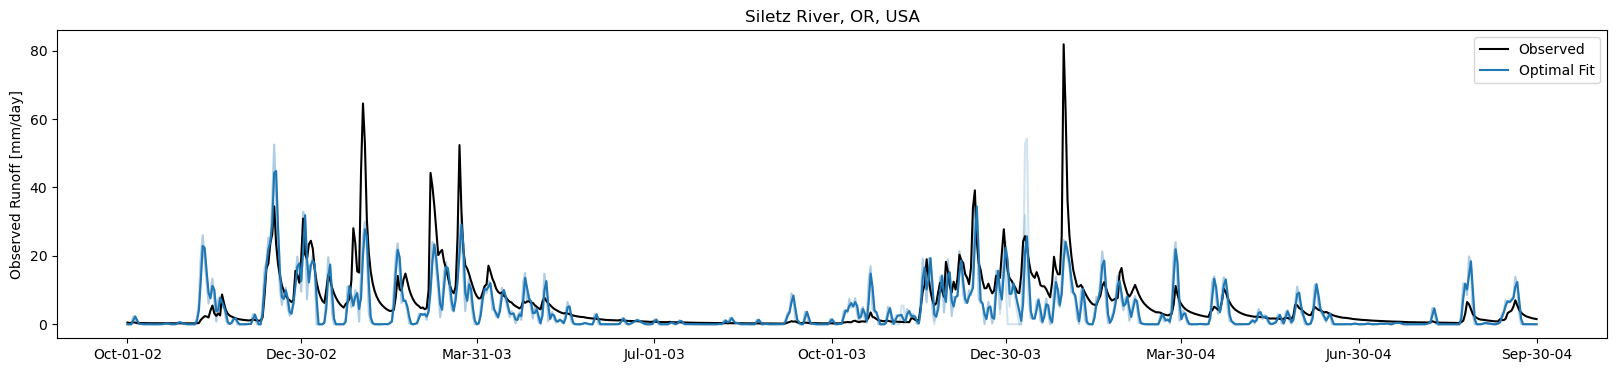

In [6]:
n_calibrations = 3
max_iter = max_iter_spn.value
bounds   = np.array([bound_rng.value for bound_rng in bounds_rng])
OF       = objective_functions[dropdown_of.value]
check_of_implemented()  

### OPTIMIZE HBV MODEL FOR CATCHMENT

print(f"Optimizing HBV for {catchment_name} with objective function {dropdown_of.value} (iterating up to {max_iter} times)\n")

optimal_parameters = {}
for cal_round in range(n_calibrations):
    
    # initial guess for parameters from uniform distribution
    x0 = np.random.uniform(low=bounds_min, high=bounds_max)
    print(f"{cal_round + 1}. Trial")
    print(f"   Initial parameters: " + ", ".join([f"{name}: {value:.2f}" for name, value in zip(parameters, x0)]))

    # run the differntial evoluation algorithm to optimize the parameters
    # for more info press Shift + Tab on function call or read https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html
    hbv_calibrated = differential_evolution(loss_hbv, bounds=bounds, args=(P, evap, q_obs, OF, spinup_days), x0=x0, maxiter=max_iter)
    x_optimal = hbv_calibrated.x

    # store the results of the optimization run for later plotting
    optimal_parameters[hbv_calibrated.fun] = x_optimal
    
    print("   " + hbv_calibrated.message)
    print("   Resulting parameters: " + ", ".join([f"{name}: {value:.2f}" for name, value in zip(parameters, x_optimal)]))
    print(f"   (This is based on the best found result for {dropdown_of.value}: {hbv_calibrated.fun:.2e})\n")


### PLOT the RESULTING FIT

plt.figure(figsize=(20, 4))

# plot the optimized solutions
[plt.plot(df_obs["Date"], hbv(params, P, evap), color="C0", alpha=0.2) for i, params in enumerate(optimal_parameters.values())]

# plot the observed runoff data
plt.plot(df_obs["Date"], df_obs["Q [mm/day]"], color="black", label="Observed")

# plot the optimal solution
plt.plot(df_obs["Date"], hbv(optimal_parameters[min(optimal_parameters.keys())], P, evap), color="C0", label="Optimal Fit")

plt.ylabel("Observed Runoff [mm/day]")
plt.title(catchment_name)
plt.gca().xaxis.set_major_locator(mdate.MonthLocator(bymonth=[1,4,7,10]))
plt.legend()
plt.show()

<div style="background:#e0f2fe; padding: 1%; border: 1mm solid SkyBlue">
    <h4><span>&#129300 </span>Your Turn II: Using Global Optimization</h4>
    <ol>
        <li> Run the optimization for different catchments and different objective functions (change the variable "OF"). Compare the result of the different catchments! Where does the model perform better or worse (remember, what climatic regions the individual catchments represent)?</li>
        <li>Why do results of the optimized objective functions change between the trials?</li>
        <li>Why do, for the same results of the optimized objective function, some input parameters vary significantly?</li>
        <li>Write your own implementation of an objective function of your choice</li>
        <br>
        <p><i>Below, we have prepared two empty functions that are not yet implemented. You may choose any of the ones we used in previous tutorials or implement completely new ones. You can then use your new function with the optimization code above</i></p>
    </ol>
</div>

In [7]:
def yourOF1(obs, sim):
    return bias(obs, sim) # TODO: remove and implement your own OF

def yourOF2(obs, sim):
    raise NotImplementedError() # TODO: remove and implement your own OF

# please do not remove this
objective_functions = {"Bias":bias, "RMSE": rmse, "1-NSE": one_minus_nse, "Your OF 1": yourOF1, "Your OF 2": yourOF2}